# Fine-tuning a Wav2vec Model for Automatic Speech Recognition

**Name**: Hawawou Oumarou Tchapchet

The ASR system used in the first two labs relied on an acoustic model made up of two main components: a *feature* extractor (based on the [wav2vec](https://arxiv.org/pdf/2006.11477) architecture) and a *classifier* (a linear layer). The model then operates in two stages:

1. The speech waveform is passed to the feature extractor to transform it into a latent representation (= the *feature maps*).
2. The latent representation is passed to a classification layer to compute the probability of each character (= the *emission matrix*).

<center><img src="https://github.com/magronp/magronp.github.io/blob/master/images/wav2vec2asr.png?raw=true" width="800"></center>

To train such a model in practice, a two-stage proces is used. First, the wav2vec model alone is pre-trained in a self-supervised manner (using speech data only). Then, the classification layer is added and the whole model \{wav2vec+classifier\} is fine-tuned in a supervised manner (from speech+transcript data).

In the previous labs, we have used a whole model that was already pre-trained and fine-tuned for ASR. In this lab, we start from the pre-trained wav2vec model, and we reproduce the process of fine-tuning it for ASR. 

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchaudio
import IPython
import os
import fnmatch
import copy
import matplotlib.pyplot as plt
torch.random.manual_seed(0)

MAX_FILES = 100 # lower this number for processing a subset of the dataset

In [3]:
# Main dataset path - Only change it HERE if needed and not later in the notebook
data_dir = "/home/oumar/School/M2_NLP/Speech/asr-dataset/"

In [4]:
# Speech and transcripts sub-directories paths
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## Preparation

In [5]:
# Example file
audio_file = '61-70968-0001.wav'
audio_file_path = os.path.join(data_speech_dir, audio_file)
print(f"Audio file path: {audio_file_path}")

waveform, sr = torchaudio.load(audio_file_path, channels_first=True)
IPython.display.Audio(data=waveform, rate=sr)

Audio file path: /home/oumar/School/M2_NLP/Speech/asr-dataset/speech/61-70968-0001.wav


In [6]:
# Function to load a transcript; the preprocessing here is a bit different than in previous labs (more convenient for training)
def get_true_transcript(transc_file_path):
    with open(transc_file_path, "r") as f:
        true_transcript = f.read()
    true_transcript = true_transcript.lower().replace(' ','|').replace('\n','')
    return true_transcript

# Load and display the true transcription
transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))
true_transcript = get_true_transcript(transc_file_path)
print(true_transcript)

give|not|so|earnest|a|mind|to|these|mummeries|child


In [7]:
# We provide the list of labels (=characters) that can be found in the dataset
labels = ['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm',
          'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']
n_labels = len(labels)

We need to transform the true transcript into a list of integers in order to feed it to a training loss function. To that end, we define a dictionary `dico_labels` that maps each character in the list of possible labels to an integer (for instance, `dico_labels['e']=2` or `dico_labels['a']=4`).

In [8]:
# TODO: using the 'labels' list above, define this dictionary
dico_labels = {labels[i]:i for i in range(n_labels)}


In [9]:
# Apply dico_labels to the true transcript, and build a tensor from it
target_indices = [dico_labels[c] for c in true_transcript]
target_indices = torch.tensor(target_indices, dtype=torch.long)
print(target_indices)

tensor([18,  7, 22,  2,  1,  6,  5,  3,  1,  9,  5,  1,  2,  4, 10,  6,  2,  9,
         3,  1,  4,  1, 14,  7,  6, 11,  1,  3,  5,  1,  3,  8,  2,  9,  2,  1,
        14, 13, 14, 14,  2, 10,  7,  2,  9,  1, 16,  8,  7, 12, 11])


## Acoustic model

Torchaudio comprises many models whose pretrained weights can be loaded directly (the list can be found [here](https://pytorch.org/audio/stable/pipelines.html#id3)). Here we use `WAV2VEC2_BASE`, which is pre-trained on speech data, but not fine-tuned for ASR.

We can apply it to the waveform to compute the feature maps, which is a tensor of size `[1, time steps, feature dim]` (recall that `1` corresponds to the batch size).

In [10]:
# Load the acoustic model: here it's a Wav2vec that is not fine-tuned
model_name = 'WAV2VEC2_BASE'
bundle = getattr(torchaudio.pipelines, model_name)
wav2vec = bundle.get_model()

# Display model architecture
print(wav2vec)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [11]:
# Compute the feature maps
with torch.inference_mode():
    features, _ = wav2vec(waveform)

print(features.shape)

torch.Size([1, 180, 768])


<span style="color:red"> **Exercise 1**</span>. Complete the `Wav2vecASR` model class below. This model includes a wav2vec feature extractor (loaded above) and a linear classification layer that takes the feature maps and output log-probabilities per class (thus it has to use a [log softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) activation after classification).

In [12]:
class Wav2vecASR(nn.Module):
    def __init__(self, wav2vec, output_size):
        super().__init__()
        self.wav2vec = wav2vec
        self.linear = nn.Linear(768, output_size)
        self.log_softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x):
        features, _ = self.wav2vec(x)
        y = self.linear(features)
        y = self.log_softmax(y)
        return y

In [13]:
# Instanciate the model
output_size = n_labels
print(f"Output size: {output_size}")
model = Wav2vecASR(wav2vec, output_size)

Output size: 29


In [14]:
# A function to count the number of trainable parameters
def count_tlearnable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_tlearnable_params(model))

Number of trainable parameters: 94393245


The model is very large (90M+ parameters) mostly because of the wav2vec part. To speed training in this lab, we freeze the wav2vec part and we only train the classification layer. To that end, we need to set `requires_grad = False` for the wav2vec's parameters.

In [15]:
# TODO: Define a function to freeze parameters, apply it to "wav2vec" part of the model,
# and print the new number of trainable parameters

def freeze_params(model):
    for param in model.wav2vec.parameters():
        param.requires_grad = False
    return model

model = freeze_params(model)
print('Number of trainable parameters:', count_tlearnable_params(model))



Number of trainable parameters: 22301


In [16]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return model 


In [17]:
# TODO: Apply the initialization function to the classification layer of the model
model.apply(init_params)


Wav2vecASR(
  (wav2vec): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 768, kernel_

torch.Size([1, 180, 29])


Text(0.5, 1.0, 'Emission matrix')

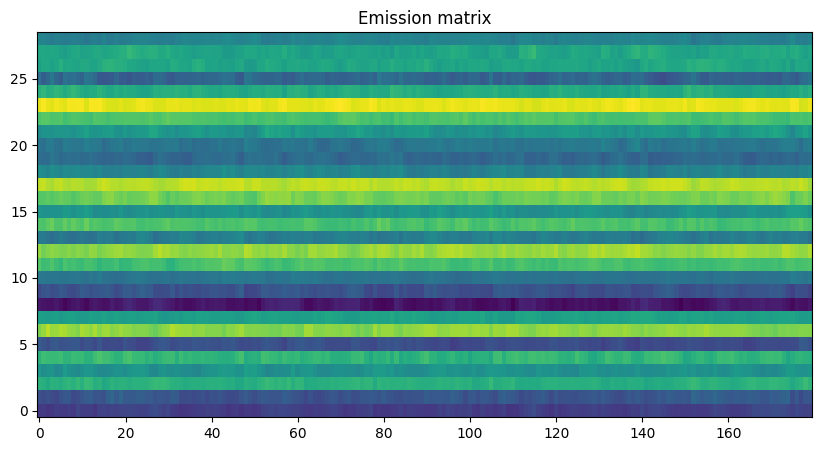

In [18]:
# TODO: apply the model to the waveform to compute the emission matrix, print its shape and plot it
emission = model(waveform)
print(emission.shape)

plt.figure(figsize=(10, 5))
plt.imshow(emission.squeeze().detach().numpy().T, aspect='auto', origin='lower')
plt.title('Emission matrix')



In [19]:
# We provide a function to get a transcript from the emission matrix (similar to the greedy decoder from lab 1)
def transcript_from_emission(emission, labels):
    indices = torch.argmax(emission, dim=-1)  # take the most likely index at each time step
    indices = torch.unique_consecutive(indices, dim=-1) # remove duplicates
    indices = [i for i in indices if i != 0] # remove the blank token
    transcript = "".join([labels[i] for i in indices]) # convert integers back into characters
    transcript = transcript.lower()
    return transcript

# The transcript using a non-trained model should look bad
print(transcript_from_emission(emission[0], labels))

k


## Dataset

We now need to define the `Dataset` class, to efficiently load the speech data and true transcript (in the form of indices / integers).

<span style="color:red"> **Exercise 2**</span>. Complete the `ASRdataset` class below (`__init__`, `__len__`, and `__getitem__` methods). In particular, the `__getitem__` method should return three outputs:
- `waveform`: a tensor containing the speech waveform
- `true_transcript`: the true transcript as per using the provided loading function
- `target_indices`: a tensor containing the integers corresponding to the transcript

The `__init__` method should make use of the `MAX_FILES` variable to limit the size of the dataset (for speed).

In [20]:
# ASR Dataset class
class ASRdataset(Dataset):
    def __init__(self, data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=None):
        self.data_speech_dir = data_speech_dir
        self.data_transc_dir = data_transc_dir
        self.dico_labels = dico_labels
        self.MAX_FILES = MAX_FILES
        self.files = self._find_files(data_speech_dir)
        if MAX_FILES is not None:
            self.files = self.files[:MAX_FILES]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        audio_file = self.files[index]
        audio_file_path = os.path.join(self.data_speech_dir, audio_file)
        waveform, sr = torchaudio.load(audio_file_path, channels_first=True)
        waveform = waveform.squeeze(0)
        true_transcript = get_true_transcript(os.path.join(self.data_transc_dir, audio_file.replace('wav', 'txt')))
        target_indices = [self.dico_labels[c] for c in true_transcript]
        target_indices = torch.tensor(target_indices, dtype=torch.long)
        return waveform, true_transcript, target_indices
        

    
    def _find_files(self, directory, pattern='*.wav'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(filename)
        files = sorted(files)
        return files


In [21]:
# Instanciate the ASR dataset and print its length
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)
print('Dataset length:', len(asrdataset))

# Get the first data sample, and print some information
waveform, true_transcript, target_indices = asrdataset[0]
print(waveform.shape)
print(true_transcript)
print(target_indices)

Dataset length: 100
torch.Size([70560])
angor|pain|painful|to|hear
tensor([ 4,  6, 18,  5, 10,  1, 20,  4,  7,  6,  1, 20,  4,  7,  6, 17, 13, 12,
         1,  3,  5,  1,  8,  2,  4, 10])


In real-life applications (and as we usually do in the "Neural Networks" labs), we assemble the data samples into *batches* for efficiency. However, our data points here have different lenghts in general: two speech waveforms / two transcripts are not guaranteed to have the same duration / number of characters. Therefore, in such a case we need to customize the dataloader such that it performs some [padding operation](https://www.codefull.org/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/) in order to yield data samples of same length. However, to keep things simple in this lab, we skip this padding operation, and we do not work with batches but rather iterate over the dataset directly.

## Training with the CTC loss

For a given data sample in the dataset, we have:
- the emission matrix (log-probability of each character over time frames)
- the true transcript (represented as a list of integers corresponding to each character)

However, to train our network, we need to obtain an estimated transcript so that we can compute a loss between the true and estimated transcripts. This requires some post-processing of the emission matrix, but the good news is that we don't have to do it, the [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) handles that for us!

In lab 2 we have use the CTC algorithm to perform inference, but it can also be used as a loss function to train an ASR network. Not only the CTC loss handles the post-processing from the emission matrix, but its great advantage is that it performs alignment from input/output pairs of different lengths, so we don't have to explicitly align each character in the transcript with a time frame in the emission matrix.

In Pytorch, [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) is fed with the the emission matrix and the tensor containing target indices (corresponding to the true transcript). We also need to give it the input and target lengths explicitly: indeed, even though here we don't manipulate batches / we don't do padding, in general this would be the case so we need to let the function know what is the actual input/target length (before padding).

In [22]:
# Compute the emission matrix (not in inference mode such that we keep track of the gradients)
emission = model(waveform.unsqueeze(0))
emission = emission[0] #remove the "batch" dimension (since here batch_size=1)

# Define the input and target lengths as tensors
T = emission.shape[0]
L = len(target_indices)
input_length = torch.tensor(T, dtype=torch.long)
target_length = torch.tensor(L, dtype=torch.long)

# Instanciate a loss object
ctc_loss = nn.CTCLoss()

# Compute the loss
loss = ctc_loss(emission, target_indices, input_length, target_length)
print(loss.item())

# Compute the gradients
loss.backward()

20.876569747924805


<span style="color:red"> **Exercise 3**</span>. Write the training function `training_wav2vecASR` to train the model. It is similar to what we usually do in the Neural Networks labs, although here we do not build batches of data (thus we don't need a `Dataloader` object). Instead, we directly iterate over the `Dataset`. The training function uses an Adam optimizer, and no validation.

In [23]:
def training_wav2vecASR(model, train_data, num_epoch, loss_fn, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = loss_fn
    train_losses = [] 

    model.train()

    for epoch in range(num_epoch):
        total_loss = 0
        for i, (waveform, true_transcript, target_indices) in enumerate(train_data):
            optimizer.zero_grad()
            emission = model(waveform.unsqueeze(0))
            emission = emission[0]

            T = emission.shape[0]
            L = len(target_indices)
            input_length = torch.tensor(T, dtype=torch.long)
            target_length = torch.tensor(L, dtype=torch.long)

            ctc_loss = loss(emission, target_indices, input_length, target_length)

            ctc_loss.backward()
            optimizer.step()
            total_loss += ctc_loss.item()
            if i % 10 == 0:
                print(f'Epoch {epoch}, loss: {ctc_loss.item()}')
            train_losses.append(ctc_loss.item())

    return model, train_losses


In [24]:
# Training parameters (only one epoch for speed)
num_epochs = 1
learning_rate = 0.001
loss_fn = nn.CTCLoss()

model_tr, train_losses = training_wav2vecASR(model, asrdataset, num_epochs, loss_fn, learning_rate)

Epoch 0, loss: 20.915367126464844
Epoch 0, loss: 5.4724345207214355
Epoch 0, loss: 3.5715172290802
Epoch 0, loss: 3.576998710632324
Epoch 0, loss: 3.0790984630584717
Epoch 0, loss: 3.2864205837249756
Epoch 0, loss: 3.296297788619995
Epoch 0, loss: 3.078284502029419
Epoch 0, loss: 2.966567039489746
Epoch 0, loss: 3.056830644607544


## Overfitting on one sample

We observed above that training is slow: this is because the wav2vec model is rather large so the forward pass takes some time (even though the gradients are not tracked), and also because we did not assemble data into batches.

Nonetheless, we can assess that our training pipeline works properly by conducting training on a unique sample, and checking the transcript on the same sample. This technique (= overfitting on one sample) is useful to "crash test" if everything runs and if our model / training pipeline has any chance to work on a larger dataset.

<span style="color:red"> **Exercise 4**</span>. Instanciate a model from scratch, freeze the wav2part, and initialize the classification layer. Build a dataset made up of 1 sample (use the `MAX_FILES` parameter), and conduct training for 50 epoch using this dataset. Once the model is trained, compute the emission matrix from this sample's waveform and the estimated transcript. Display the true and estimated transcripts. Also do the same on another sentence so that you can assess that the model is not able to generalize properly.

In [25]:
def overfitting_wav2vecASR(wav2vec, output_size):
    model = Wav2vecASR(wav2vec, output_size)
    model = freeze_params(model)
    model.apply(init_params)

    return model
output_size = len(dico_labels)
model = overfitting_wav2vecASR(wav2vec, output_size)

In [26]:
one_asrdata = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES = 1)
waveform, true_transcript, target_indices = one_asrdata[0]
print(true_transcript)



angor|pain|painful|to|hear


In [27]:
def overfitting(model, dataset, num_epochs, learning_rate):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CTCLoss()
    model.train()
    
    for epoch in range(num_epochs):
        waveform, true_transcript, target_indices = dataset[0]
        
        emission = model(waveform.unsqueeze(0))[0]

        input_length = torch.tensor([emission.shape[0]], dtype=torch.long)
        target_length = torch.tensor([len(target_indices)], dtype=torch.long)
        
        emission = emission.unsqueeze(1) 
        target_indices = target_indices.unsqueeze(0)  
        
        loss = loss_fn(emission, target_indices, input_length, target_length)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item():.4f}")

    return model, emission


trained_model, emission = overfitting(model, one_asrdata, num_epochs=50, learning_rate=0.001)

Epoch 1/50 - Loss: 20.9154
Epoch 2/50 - Loss: 18.5654
Epoch 3/50 - Loss: 16.6850
Epoch 4/50 - Loss: 14.6185
Epoch 5/50 - Loss: 13.2479
Epoch 6/50 - Loss: 11.7323
Epoch 7/50 - Loss: 10.8200
Epoch 8/50 - Loss: 9.0105
Epoch 9/50 - Loss: 8.5138
Epoch 10/50 - Loss: 7.5034
Epoch 11/50 - Loss: 6.9690
Epoch 12/50 - Loss: 6.6379
Epoch 13/50 - Loss: 6.3832
Epoch 14/50 - Loss: 6.2092
Epoch 15/50 - Loss: 6.1000
Epoch 16/50 - Loss: 6.0114
Epoch 17/50 - Loss: 5.9533
Epoch 18/50 - Loss: 5.9096
Epoch 19/50 - Loss: 5.8718
Epoch 20/50 - Loss: 5.9192
Epoch 21/50 - Loss: 5.8963
Epoch 22/50 - Loss: 5.8155
Epoch 23/50 - Loss: 5.7606
Epoch 24/50 - Loss: 5.7064
Epoch 25/50 - Loss: 5.7188
Epoch 26/50 - Loss: 5.6831
Epoch 27/50 - Loss: 5.6728
Epoch 28/50 - Loss: 5.6381
Epoch 29/50 - Loss: 5.5956
Epoch 30/50 - Loss: 5.5474
Epoch 31/50 - Loss: 5.5601
Epoch 32/50 - Loss: 5.5338
Epoch 33/50 - Loss: 5.4900
Epoch 34/50 - Loss: 5.4980
Epoch 35/50 - Loss: 5.5197
Epoch 36/50 - Loss: 5.4671
Epoch 37/50 - Loss: 5.4572
Epo

torch.Size([1, 220, 29])


Text(0.5, 1.0, 'Emission matrix')

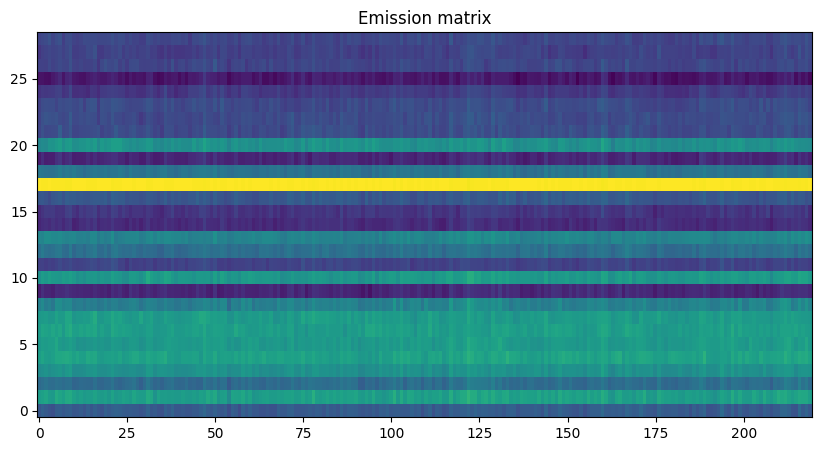

In [28]:
emission = trained_model(waveform.unsqueeze(0))
print(emission.shape)

plt.figure(figsize=(10, 5))
plt.imshow(emission.squeeze().detach().numpy().T, aspect='auto', origin='lower')
plt.title('Emission matrix')

In [29]:
print(transcript_from_emission(emission[0], labels))

f


In [35]:
asrdata_2 = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES = 2)
waveform, true_transcript, target_indices = asrdata_2[1]
print(true_transcript)

heaven|a|good|place|to|be|raised|to


In [36]:
trained_model, emission = overfitting(model, asrdata_2, num_epochs=50, learning_rate=0.001)

Epoch 1/50 - Loss: 6.0547
Epoch 2/50 - Loss: 5.2940
Epoch 3/50 - Loss: 5.3197
Epoch 4/50 - Loss: 5.3437
Epoch 5/50 - Loss: 5.2815
Epoch 6/50 - Loss: 5.2481
Epoch 7/50 - Loss: 5.2038
Epoch 8/50 - Loss: 5.6387
Epoch 9/50 - Loss: 5.1412
Epoch 10/50 - Loss: 5.1293
Epoch 11/50 - Loss: 5.5211
Epoch 12/50 - Loss: 5.2046
Epoch 13/50 - Loss: 5.0913
Epoch 14/50 - Loss: 5.1512
Epoch 15/50 - Loss: 5.2155
Epoch 16/50 - Loss: 5.2139
Epoch 17/50 - Loss: 5.1877
Epoch 18/50 - Loss: 5.1531
Epoch 19/50 - Loss: 5.1669
Epoch 20/50 - Loss: 5.0936
Epoch 21/50 - Loss: 5.0753
Epoch 22/50 - Loss: 5.1502
Epoch 23/50 - Loss: 5.1831
Epoch 24/50 - Loss: 5.0983
Epoch 25/50 - Loss: 5.1082
Epoch 26/50 - Loss: 5.0496
Epoch 27/50 - Loss: 5.0712
Epoch 28/50 - Loss: 4.8829
Epoch 29/50 - Loss: 5.3142
Epoch 30/50 - Loss: 5.1763
Epoch 31/50 - Loss: 5.1231
Epoch 32/50 - Loss: 5.1505
Epoch 33/50 - Loss: 5.1391
Epoch 34/50 - Loss: 5.1328
Epoch 35/50 - Loss: 5.0567
Epoch 36/50 - Loss: 4.9750
Epoch 37/50 - Loss: 5.0678
Epoch 38/5

torch.Size([1, 200, 29])


Text(0.5, 1.0, 'Emission matrix')

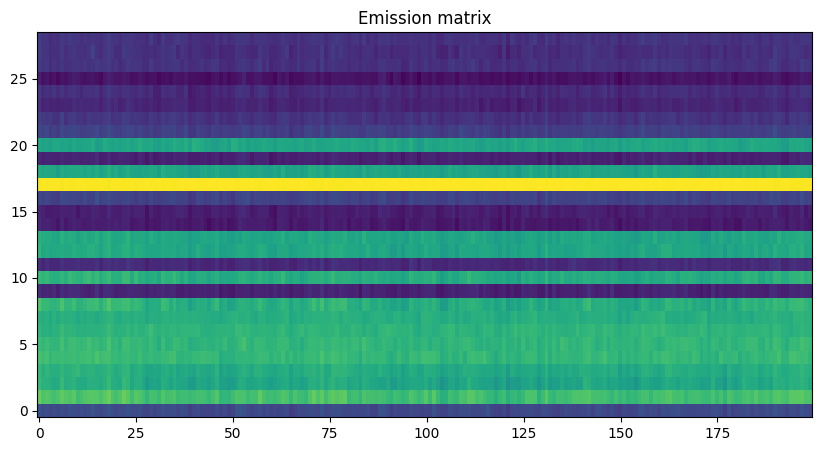

In [37]:
emission = trained_model(waveform.unsqueeze(0))
print(emission.shape)

plt.figure(figsize=(10, 5))
plt.imshow(emission.squeeze().detach().numpy().T, aspect='auto', origin='lower')
plt.title('Emission matrix')

In [38]:
print(transcript_from_emission(emission[0], labels))

f
